# Compute GitHub Stats

In [1]:
# NOTE: The RuntimeWarnings (if any) are harmless. See ContinuumIO/anaconda-issues#6678.
from pandas.io import gbq
import pandas as pd
import numpy as np

# Use plotly cufflinks to plot data frames
# https://plot.ly/ipython-notebooks/cufflinks/
# instructions for offline plotting
# https://plot.ly/python/getting-started/#initialization-for-offline-plotting
#
# Follow the instructions for online plotting:
# https://plot.ly/python/getting-started/
# You will need to setup an account
# TODO(jlewi): Use Altair for visualization?
import plotly
#import plotly.plotly as py
#import plotly.graph_objs as go
#import cufflinks as cf
from importlib import reload
import itertools

In [2]:
import getpass
import subprocess
# Configuration Variables. Modify as desired.

PROJECT = subprocess.check_output(["gcloud", "config", "get-value", "project"]).strip().decode()

## Setup Authorization

If you are using a service account run
%%bash

# Activate Service Account provided by Kubeflow.
gcloud auth activate-service-account --key-file=${GOOGLE_APPLICATION_CREDENTIALS}

If you are running using user credentials

gcloud auth application-default login

In [3]:
import datetime
datetime.datetime.now().month

10

In [4]:
months = []
for year in ["2018"]:
    for month in range(1, 13):
        months.append("\"{0}{1:02}\"".format(year, month))

        
for year in ["2019"]:
    for month in range(1, datetime.datetime.now().month + 1):
        months.append("\"{0}{1:02}\"".format(year, month))
months

['"201801"',
 '"201802"',
 '"201803"',
 '"201804"',
 '"201805"',
 '"201806"',
 '"201807"',
 '"201808"',
 '"201809"',
 '"201810"',
 '"201811"',
 '"201812"',
 '"201901"',
 '"201902"',
 '"201903"',
 '"201904"',
 '"201905"',
 '"201906"',
 '"201907"',
 '"201908"',
 '"201909"',
 '"201910"']

## Unique PR Creators

In [161]:
query = """
SELECT
    DATE(created_at) AS pr_date,
    actor.id,
    actor.login,
    JSON_EXTRACT(payload, '$.pull_request.user.id') as user_id,
    JSON_EXTRACT(payload, '$.pull_request.id') as pr_id,
    JSON_EXTRACT(payload, '$.pull_request.merged') as merged
  FROM `githubarchive.month.*`
  WHERE
    _TABLE_SUFFIX IN ({0})
    AND type = 'PullRequestEvent'
    AND org.login = 'kubeflow'
    AND JSON_EXTRACT(payload, '$.action') IN ('"closed"')
""".format(",".join(months))

all_prs=gbq.read_gbq(str(query), dialect='standard', project_id=PROJECT)

In [162]:
# Filter PRs to merged PRs
v=all_prs["merged"].values == 'true'
merged_all_prs = all_prs.iloc[v]

In [163]:
p=pd.Series(data=merged_all_prs["user_id"].values,index=merged_all_prs["pr_date"])
p=p.sort_index()

In [164]:
# Some solutions here: https://stackoverflow.com/questions/46470743/how-to-efficiently-compute-a-rolling-unique-count-in-a-pandas-time-series
# Need to figure out how to do a time based window

creators = p.rolling('28d').apply(lambda arr: pd.Series(arr).nunique())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning



In [165]:
layout = go.Layout(
    title='Unique PR Authors Last 28 Days',
    font=dict(family='Courier New, monospace', size=18, color='black')
)
creators.iplot(kind='scatter', layout=layout, width=5, filename='creator-stats')


### Number Prs

In [166]:
pr_impulse=pd.Series(data=merged_all_prs["pr_id"].values,index=merged_all_prs["pr_date"])
pr_impulse=pr_impulse.sort_index()

unique_prs = pr_impulse.rolling('28d').apply(lambda arr: pd.Series(arr).nunique())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning



In [167]:
layout = go.Layout(
    title='Unique PRs Last 28 Days',
    font=dict(family='Courier New, monospace', size=18, color='black')
)
unique_prs.iplot(kind='scatter', layout=layout, width=5, filename='pr-stats')

## Release stats per release (quarter)

* Compute stats about a release 
* We do this based on time
* You can see a sample of the payload at [https://api.github.com/repos/kubeflow/pipelines/pulls/1038](https://api.github.com/repos/kubeflow/pipelines/pulls/1038)

In [83]:
release_months = []
year = 2019


for month in range(4, 7):
    release_months.append("\"{0}{1:02}\"".format(year, month))
        

query = """
SELECT
    DATE(created_at) AS pr_date,
    actor.id,
    actor.login,
    JSON_EXTRACT(payload, '$.pull_request.merged') as merged,
    JSON_EXTRACT(payload, '$.pull_request.id') as pr_id,
    JSON_EXTRACT(payload, '$.pull_request.url') as pr_url,
    JSON_EXTRACT(payload, '$.pull_request.user.id') as user_id
  FROM `githubarchive.month.*`
  WHERE
    _TABLE_SUFFIX IN ({0})
    AND type = 'PullRequestEvent'
    AND org.login = 'kubeflow'
    AND JSON_EXTRACT(payload, '$.action') IN ('"closed"')
""".format(",".join(release_months))

prs=gbq.read_gbq(str(query), dialect='standard', project_id=PROJECT)

In [84]:
# Filter PRs to merged PRs
v=prs["merged"].values == 'true'
merged_prs = prs.iloc[v]

In [12]:
unique_pr_logins = prs["user_id"].unique()
unique_prs = prs["pr_id"].unique()

merged_unique_logins = merged_prs["user_id"].unique()
merged_unique_prs = merged_prs["pr_id"].unique()
print("Number of unique pr authors (merged & unmerged) {0}".format(unique_pr_logins.shape))
print("Number of unique prs (merged & unmerged) {0}".format(unique_prs.shape))
print("Number of unique pr authors (merged) {0}".format(merged_unique_logins.shape))
print("Number of unique prs (merged) {0}".format(merged_unique_prs.shape))

NameError: name 'prs' is not defined

## Get a list of distinct actions

* Here's a list of events in the [api](https://developer.github.com/v4/union/pullrequesttimelineitems/)
* It looks like these are different from the ones in the github archive

In [5]:
query = """
SELECT
    distinct JSON_EXTRACT(payload, '$.action')
  FROM `githubarchive.month.*`
  WHERE
    _TABLE_SUFFIX IN ({0})    
""".format(",".join(months))

actions=gbq.read_gbq(str(query), dialect='standard', project_id=PROJECT)

/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:66: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/



In [6]:
actions

,f0_
0,"""reopened"""
1,"""closed"""
2,"""added"""
3,"""started"""
4,None
5,"""published"""
6,"""opened"""
7,"""created"""


## New Issues Last 28 Days

In [21]:
query = """
SELECT
    DATE(created_at) AS issue_date,
    actor.id,
    actor.login,
    JSON_EXTRACT(payload, '$.pull_request.id') as issue_id,
    JSON_EXTRACT(payload, '$.pull_request.url') as issue_url  
  FROM `githubarchive.month.*`
  WHERE
    _TABLE_SUFFIX IN ({0})
    AND type = 'IssuesEvent'
    AND org.login = 'kubeflow'
    AND JSON_EXTRACT(payload, '$.action') IN ('"opened"')
""".format(",".join(months))

issues=gbq.read_gbq(str(query), dialect='standard', project_id=PROJECT)

In [45]:
issue_counts=issues["issue_date"].value_counts()
issue_counts=issue_counts.sort_index()
rolling_issue_count = issue_counts.rolling('28d').sum()

In [49]:
%matplotlib

Using matplotlib backend: GTK3Agg


Text(0, 0.5, '# Of Issues')

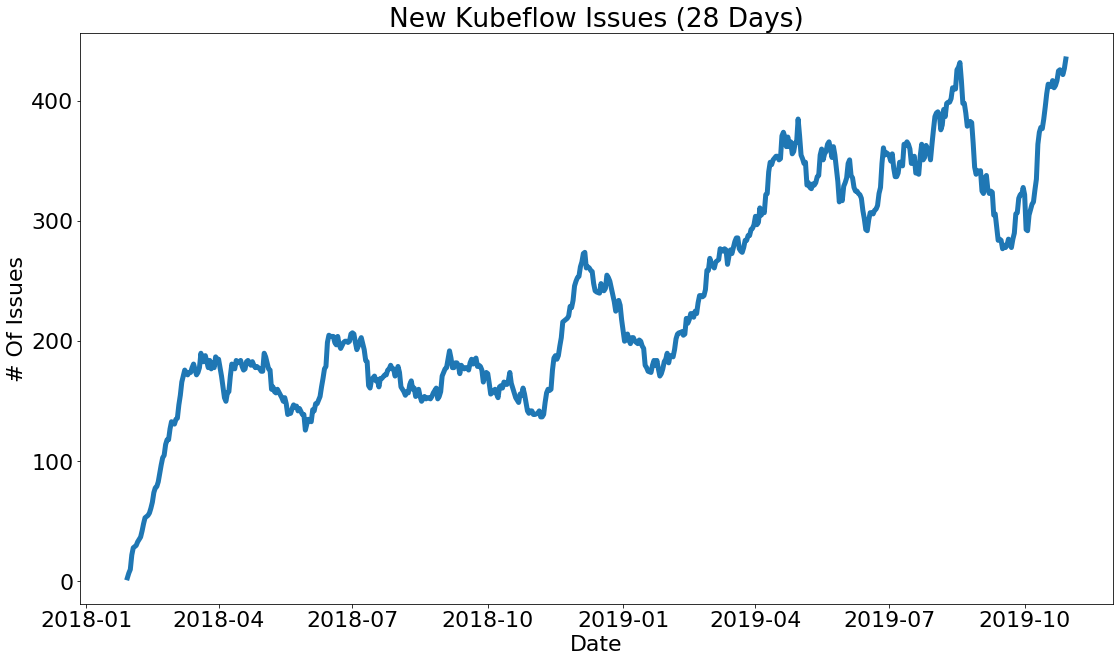

In [60]:
import matplotlib
from matplotlib import pylab
matplotlib.rcParams.update({'font.size': 22})
hf = pylab.figure()
hf.set_size_inches(18.5, 10.5)
pylab.plot(rolling_issue_count, linewidth=5)
ha = pylab.gca()
ha.set_title("New Kubeflow Issues (28 Days)")
ha.set_xlabel("Date")
ha.set_ylabel("# Of Issues")



NameError: name 'matplotlib' is not defined

## GetSomeSampleIssue Events

In [19]:
query = """
SELECT
    *
  FROM `githubarchive.month.*`
  WHERE
    _TABLE_SUFFIX IN ({0})
    AND type = 'IssuesEvent'
    AND org.login = 'kubeflow'
    
    limit 20
""".format(",".join(months))

events=gbq.read_gbq(str(query), dialect='standard', project_id=PROJECT)

In [20]:
events

,type,public,payload,repo,actor,org,created_at,id,other
0,IssuesEvent,True,"{""action"":""opened"",""issue"":{""url"":""https://api...","{'id': 112647343, 'name': 'kubeflow/kubeflow',...","{'id': 2348401, 'login': 'cwbeitel', 'gravatar...","{'id': 33164907, 'login': 'kubeflow', 'gravata...",2019-03-02 17:09:16+00:00,9167839459,"{""actor"":{""display_login"":""cwbeitel""}}"
1,IssuesEvent,True,"{""action"":""opened"",""issue"":{""url"":""https://api...","{'id': 112647343, 'name': 'kubeflow/kubeflow',...","{'id': 5303018, 'login': 'avdaredevil', 'grava...","{'id': 33164907, 'login': 'kubeflow', 'gravata...",2019-03-04 23:09:36+00:00,9178466998,"{""actor"":{""display_login"":""avdaredevil""}}"
2,IssuesEvent,True,"{""action"":""closed"",""issue"":{""url"":""https://api...","{'id': 112647343, 'name': 'kubeflow/kubeflow',...","{'id': 20407524, 'login': 'k8s-ci-robot', 'gra...","{'id': 33164907, 'login': 'kubeflow', 'gravata...",2019-03-04 20:12:06+00:00,9177431255,"{""actor"":{""display_login"":""k8s-ci-robot""}}"
3,IssuesEvent,True,"{""action"":""opened"",""issue"":{""url"":""https://api...","{'id': 95700338, 'name': 'kubeflow/tf-operator...","{'id': 4527219, 'login': 'cndaimin', 'gravatar...","{'id': 33164907, 'login': 'kubeflow', 'gravata...",2019-03-01 02:49:00+00:00,9159500300,"{""actor"":{""display_login"":""cndaimin""}}"
4,IssuesEvent,True,"{""action"":""closed"",""issue"":{""url"":""https://api...","{'id': 119692762, 'name': 'kubeflow/testing', ...","{'id': 777219, 'login': 'jlewi', 'gravatar_id'...","{'id': 33164907, 'login': 'kubeflow', 'gravata...",2018-02-13 01:59:45+00:00,7235666296,"{""actor"":{""display_login"":""jlewi""}}"
5,IssuesEvent,True,"{""action"":""opened"",""issue"":{""url"":""https://api...","{'id': 127941481, 'name': 'kubeflow/katib', 'u...","{'id': 31112157, 'login': 'andreyvelich', 'gra...","{'id': 33164907, 'login': 'kubeflow', 'gravata...",2018-11-17 01:30:08+00:00,8605576018,"{""actor"":{""display_login"":""andreyvelich""}}"
6,IssuesEvent,True,"{""action"":""closed"",""issue"":{""url"":""https://api...","{'id': 112647343, 'name': 'kubeflow/kubeflow',...","{'id': 20407524, 'login': 'k8s-ci-robot', 'gra...","{'id': 33164907, 'login': 'kubeflow', 'gravata...",2019-03-01 16:32:01+00:00,9163704697,"{""actor"":{""display_login"":""k8s-ci-robot""}}"
7,IssuesEvent,True,"{""action"":""opened"",""issue"":{""url"":""https://api...","{'id': 112647343, 'name': 'kubeflow/kubeflow',...","{'id': 146453, 'login': 'kkasravi', 'gravatar_...","{'id': 33164907, 'login': 'kubeflow', 'gravata...",2019-03-01 21:38:25+00:00,9165419720,"{""actor"":{""display_login"":""kkasravi""}}"
8,IssuesEvent,True,"{""action"":""opened"",""issue"":{""url"":""https://api...","{'id': 112647343, 'name': 'kubeflow/kubeflow',...","{'id': 11134742, 'login': 'kimwnasptd', 'grava...","{'id': 33164907, 'login': 'kubeflow', 'gravata...",2019-03-01 19:39:05+00:00,9164793975,"{""actor"":{""display_login"":""kimwnasptd""}}"
9,IssuesEvent,True,"{""action"":""opened"",""issue"":{""url"":""https://api...","{'id': 112647343, 'name': 'kubeflow/kubeflow',...","{'id': 777219, 'login': 'jlewi', 'gravatar_id'...","{'id': 33164907, 'login': 'kubeflow', 'gravata...",2019-03-01 19:42:21+00:00,9164811894,"{""actor"":{""display_login"":""jlewi""}}"


## Get some sample pull request events 

* Want to inspect the data


In [28]:
query = """
SELECT
    *
  FROM `githubarchive.month.*`
  WHERE
    _TABLE_SUFFIX IN ({0})
    AND type = 'PullRequestEvent'
    AND org.login = 'kubeflow'
    
    limit 20
""".format(",".join(months))

events=gbq.read_gbq(str(query), dialect='standard', project_id=PROJECT)

In [32]:
import pprint
import json
data = json.loads(events["payload"].values[3])
pprint.pprint(data)

{'action': 'closed',
 'number': 1038,
 'pull_request': {'_links': {'comments': {'href': 'https://api.github.com/repos/kubeflow/pipelines/issues/1038/comments'},
                             'commits': {'href': 'https://api.github.com/repos/kubeflow/pipelines/pulls/1038/commits'},
                             'html': {'href': 'https://github.com/kubeflow/pipelines/pull/1038'},
                             'issue': {'href': 'https://api.github.com/repos/kubeflow/pipelines/issues/1038'},
                             'review_comment': {'href': 'https://api.github.com/repos/kubeflow/pipelines/pulls/comments{/number}'},
                             'review_comments': {'href': 'https://api.github.com/repos/kubeflow/pipelines/pulls/1038/comments'},
                             'self': {'href': 'https://api.github.com/repos/kubeflow/pipelines/pulls/1038'},
                             'statuses': {'href': 'https://api.github.com/repos/kubeflow/pipelines/statuses/e52b309bc7bfd483ff066060ec9c539b

In [33]:
data["pull_request"]["id"]

{'url': 'https://api.github.com/repos/kubeflow/pipelines/pulls/1038',
 'id': 264277499,
 'node_id': 'MDExOlB1bGxSZXF1ZXN0MjY0Mjc3NDk5',
 'html_url': 'https://github.com/kubeflow/pipelines/pull/1038',
 'diff_url': 'https://github.com/kubeflow/pipelines/pull/1038.diff',
 'patch_url': 'https://github.com/kubeflow/pipelines/pull/1038.patch',
 'issue_url': 'https://api.github.com/repos/kubeflow/pipelines/issues/1038',
 'number': 1038,
 'state': 'closed',
 'locked': False,
 'title': 'Fixed some typos',
 'user': {'login': 'thedriftofwords',
  'id': 5498502,
  'node_id': 'MDQ6VXNlcjU0OTg1MDI=',
  'avatar_url': 'https://avatars2.githubusercontent.com/u/5498502?v=4',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/thedriftofwords',
  'html_url': 'https://github.com/thedriftofwords',
  'followers_url': 'https://api.github.com/users/thedriftofwords/followers',
  'following_url': 'https://api.github.com/users/thedriftofwords/following{/other_user}',
  'gists_url': 'https://api.github.co

## Get Distinct Types

In [7]:
query = """
SELECT
    distinct type
  FROM `githubarchive.month.*`
  WHERE
    _TABLE_SUFFIX IN ({0})    
    AND org.login = 'kubeflow'
    
    limit 20
""".format(",".join(months))

events=gbq.read_gbq(str(query), dialect='standard', project_id=PROJECT)

In [8]:
events

,type
0,MemberEvent
1,DeleteEvent
2,WatchEvent
3,ForkEvent
4,ReleaseEvent
5,PushEvent
6,CommitCommentEvent
7,PullRequestReviewCommentEvent
8,PublicEvent
9,CreateEvent
